# Exploratory Data Analysis

Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog.

Link: https://github.com/fastai/imagenette

(Made in Google Colab)

In [ ]:
# Mount drive (for Google Colab)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATA_PATH = 'data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')

In [ ]:
BASE_PATH = 'drive/MyDrive/Dog-Classification/'

DATA_PATH = os.path.join(BASE_PATH, DATA_PATH)
TRAIN_PATH = os.path.join(BASE_PATH, TRAIN_PATH)
VAL_PATH = os.path.join(BASE_PATH, VAL_PATH)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

from collections import Counter

## 1. Load & Preprocess Data

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.RandomOrder([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=5, scale=(0.8, 1.2), fillcolor=None),
            transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.1, hue=0.05),
            transforms.GaussianBlur(kernel_size=3)
        ]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # from ImageNet
    ])

val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # from ImageNet
    ])

train_data = datasets.ImageFolder(TRAIN_PATH, train_transform)

val_data = datasets.ImageFolder(VAL_PATH, val_transform)

image_data = {'train': train_data, 'val': val_data}

dataloader = {x: torch.utils.data.DataLoader(image_data[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

data_size = {x: len(image_data[x]) for x in ['train', 'val']}

class_name = train_data.classes

num_classes = len(class_name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Device type: {device.type}')

Device type: cpu


## 2. Data Analysis

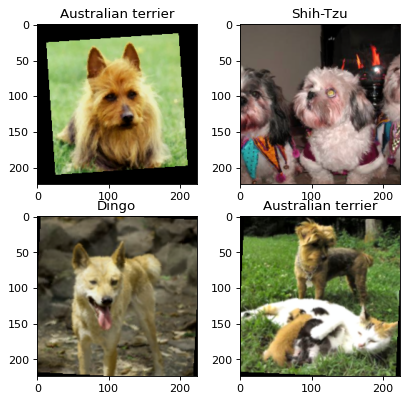

In [ ]:
def tensor_to_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    img = np.clip(inp, 0, 1)
    return img


def show_images(inputs, labels, cols=2):
    n = len(inputs)
    rows = n // cols + 1
    i = 1
    plt.figure(figsize=(3 * cols, 3 * rows), dpi=80)
    for inp, label in zip(inputs, labels):
        plt.subplot(rows, cols, i)
        plt.imshow(tensor_to_img(inp))
        plt.title(class_name[label])
        i += 1
    plt.show()


num_images = 4 # Images to show from batch
inputs, labels = next(iter(dataloader['train']))
inputs, labels = inputs[:num_images], labels[:num_images]

show_images(inputs, labels)

**Labels are correct.**

In [ ]:
class_to_idx = image_data['train'].class_to_idx
idx_to_class = {value: key for key, value in class_to_idx.items()}
class_counter = dict(Counter(image_data['train'].targets))
class_counter = {idx_to_class[key]: value for key, value in class_counter.items()}

class_counter

{'Australian terrier': 943,
 'Beagle': 932,
 'Border terrier': 949,
 'Dingo': 940,
 'English foxhound': 580,
 'Golden retriever': 949,
 'Old English sheepdog': 928,
 'Rhodesian ridgeback': 942,
 'Samoyed': 921,
 'Shih-Tzu': 941}

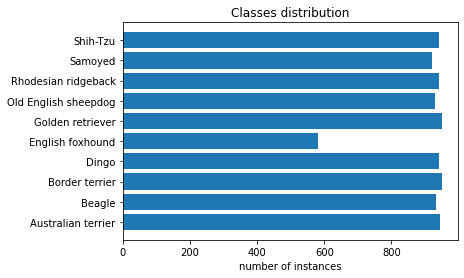

In [ ]:
plt.barh(list(class_counter.keys()), list(class_counter.values()))
plt.title('Classes distribution')
plt.xlabel('number of instances')
plt.show()

**There is no significant imbalance of classes**

So the **accuracy** metric suits us